# Lessons 1 - Introduction to deep neural networks

In [ ]:
%load_ext autoreload
%autoreload 2

## TODO

* Put dataset on the Hub with a loading script
* Figure out how to load `Dataset` objects in dataloaders
* Tidy up, add prose
* Add exercises

## Imports

In [ ]:
import numpy as np
import pandas as pd
from datasets import Dataset
from pytorch_lightning import LightningModule, Trainer
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.nn as nn
import torchmetrics
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

## Load data

In [ ]:
EVENTS_PATH = "data/QG_nsubs.npz?dl=1"

with np.load(EVENTS_PATH) as f:
    X, y = f['X'], f['y']

In [ ]:
X.shape, y.shape

((100000, 45), (100000,))

In [ ]:
data = {f"feature_{idx}":X[:, idx] for idx in range(45)}

In [ ]:
data["label"] = y

In [ ]:
df = pd.DataFrame(data)
df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,label
0,0.582885,0.359834,0.159466,0.286434,0.109313,0.031360,0.291994,0.104627,0.025298,0.269625,...,0.191827,0.045562,0.004745,0.183424,0.042593,0.004490,0.174668,0.039015,0.004060,0.0
1,0.260756,0.084642,0.019812,0.240676,0.073122,0.015786,0.225725,0.063897,0.012387,0.215447,...,0.126111,0.021134,0.002316,0.122458,0.018581,0.001079,0.117416,0.017345,0.000992,0.0
2,0.564012,0.330684,0.127177,0.292710,0.110119,0.024787,0.258846,0.086578,0.017215,0.240176,...,0.150572,0.034919,0.003328,0.147431,0.032971,0.003017,0.143079,0.031147,0.002829,0.0
3,0.395935,0.170801,0.042085,0.344588,0.130606,0.026208,0.271026,0.090233,0.017891,0.243731,...,0.164546,0.034850,0.004036,0.151774,0.029703,0.002897,0.149630,0.028986,0.002850,0.0
4,0.196304,0.051556,0.011701,0.192528,0.048644,0.010743,0.178389,0.043404,0.009060,0.172218,...,0.084400,0.012952,0.001005,0.078391,0.011012,0.000815,0.076849,0.010029,0.000572,0.0


In [ ]:
# Can't use categorical
dset = Dataset.from_pandas(df)
dset

Dataset({
    features: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34', 'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39', 'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_44', 'label'],
    num_rows: 100000
})

In [ ]:
X.shape

(100000, 45)

In [ ]:
y.shape

(100000,)

In [ ]:
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

In [ ]:
num_nsubs = 1
X = X[:, :num_nsubs]

In [ ]:
X_train, X_val, X_test = X[:75_000], X[75_000:85_000], X[85_000:]
y_train, y_val, y_test = y[:75_000], y[75_000:85_000], y[85_000:]

In [ ]:
train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)
test_ds = TensorDataset(X_test, y_test)

In [ ]:
train_dl = DataLoader(train_ds, batch_size=100, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=100)
test_dl = DataLoader(test_ds, batch_size=100)

## Define model

In [ ]:
class DNNModel(LightningModule):
    def __init__(self, nsubs = 45):
        super().__init__()
        self.nsubs = nsubs
        self.accuracy = torchmetrics.Accuracy()
        self.roc_auc = torchmetrics.AUROC(num_classes=2)
        self.layers = nn.Sequential(nn.Linear(self.nsubs, 100), nn.ReLU(), nn.Linear(100, 100), nn.ReLU(), nn.Linear(100, 2))

    def forward(self, batch):
        x, y = batch
        x = self.layers(x.view(x.size(0), -1))
        return F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        loss = F.cross_entropy(self(x), y)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss = F.cross_entropy(y_hat, y)
        self.accuracy(y_hat, y)
        self.roc_auc(y_hat, y)
        self.log("val_accuracy", self.accuracy, on_epoch=True, prog_bar=True)
        self.log("val_roc_auc", self.roc_auc, on_epoch=True, )
        self.log("val_loss", val_loss, on_epoch=True,)
        
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss = F.cross_entropy(y_hat, y)
        self.accuracy(y_hat, y)
        self.roc_auc(y_hat, y)
        self.log("test_accuracy", self.accuracy, on_epoch=True, prog_bar=True)
        self.log("test_roc_auc", self.roc_auc, on_epoch=True, )
        self.log("test_loss", val_loss, on_epoch=True,)


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)
    
    def train_dataloader(self):
        return train_dl

    def val_dataloader(self):
        return valid_dl

    def test_dataloader(self):
        return test_dl

In [ ]:
batch = next(iter(test_dl))

In [ ]:
model = DNNModel(nsubs=1)

/opt/conda/envs/dl4phys/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [ ]:
model(batch).shape

torch.Size([100, 2])

In [ ]:
model.summarize()

/opt/conda/envs/dl4phys/lib/python3.9/site-packages/pytorch_lightning/utilities/model_summary.py:471: LightningDeprecationWarning: Argument `mode` in `LightningModule.summarize` is deprecated in v1.4 and will be removed in v1.6. Use `max_depth=1` to replicate `mode=top` behavior.
  rank_zero_deprecation(


  | Name     | Type       | Params
----------------------------------------
0 | accuracy | Accuracy   | 0     
1 | roc_auc  | AUROC      | 0     
2 | layers   | Sequential | 10.5 K
----------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)

In [ ]:
trainer = Trainer(
    gpus=1,
    max_epochs=10,
    # auto_lr_find=True
    # progress_bar_refresh_rate=100,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(model, train_dataloader=train_dl, val_dataloaders=val_dl)

/opt/conda/envs/dl4phys/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:735: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | accuracy | Accuracy   | 0     
1 | roc_auc  | AUROC      | 0     
2 | layers   | Sequential | 10.5 K
----------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/envs/dl4phys/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/conda/envs/dl4phys/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
trainer.test(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/envs/dl4phys/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.6751999855041504,
 'test_loss': 0.5903524160385132,
 'test_roc_auc': 0.7281567454338074}
--------------------------------------------------------------------------------


[{'test_accuracy': 0.6751999855041504,
  'test_roc_auc': 0.7281567454338074,
  'test_loss': 0.5903524160385132}]

In [ ]:
preds = trainer.predict(model, test_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [ ]:
len(preds)

150

In [ ]:
preds_np = np.vstack(preds)

In [ ]:
preds_np.shape

(15000, 2)

In [ ]:
y_test.numpy().shape

(15000,)

In [ ]:
preds[0][0]

tensor([-0.5266, -0.8931])

In [ ]:
roc_auc_score(y_test, preds_np[:, 1])

0.7281606545078303

In [ ]:
rc = roc_curve(y_test, preds_np[:, 1])

In [ ]:
len(rc)

3

In [ ]:
rc[0].shape

(6252,)

In [ ]:
rc[1].shape

(6252,)

In [ ]:
rc[2].shape

(6252,)

(0.0, 1.0)

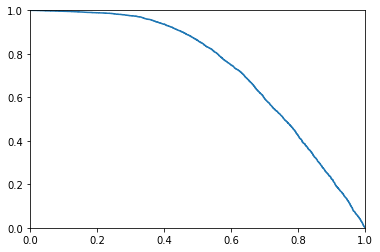

In [ ]:
plt.plot(rc[1], 1-rc[0], '-')
plt.xlim(0, 1)
plt.ylim(0, 1)